In [1]:
import sys
sys.path.insert(0,'/media/brownianxgames/Aquisitions/test_IA/mamba_classification')
sys.path.insert(0,'/media/brownianxgames/Aquisitions/test_IA/mamba_segmentation')

In [2]:
list

list

In [3]:
from train_fn import train
from train_classification import train as train_classification
from train_segmentation import train as train_segmentation

import torch

In [4]:
# result_regression, model_regression = train((4,0.1,1e-3,4))

In [ ]:
result, model = train_segmentation((1,0.05,1e-2,32))

importing gpu Mamba


Epoch 0: 100%|█| 200/200 [00:38<00:00,  5.21batch/s, loss=0.696, state0=6173, st
Epoch 1: 100%|█| 200/200 [00:36<00:00,  5.43batch/s, loss=0.694, state0=7024, st
Epoch 2:  61%|▌| 122/200 [00:22<00:14,  5.37batch/s, loss=0.693, state0=7254, st

In [6]:
# torch.save(model, "model_segmentation_2_0p1_1e-4_4_8kexps")

In [7]:
result

{'bi_mamba_stacks': 2,
 'n_layers': 4,
 'dropout': 0.1,
 'learning_rate': 0.001,
 'running_classification_total_loss': [1.1102259415388107,
  0.8054013884067536,
  0.733216917514801,
  0.7097407311201096,
  0.7030192735791206,
  0.6986064550280571,
  0.6964536800980567,
  0.6953148320317268,
  0.6945696589350701,
  0.6940681719779969]}

In [8]:
torch.randn(10,4000,1).size()

torch.Size([10, 4000, 1])

In [9]:
model
model.eval()

EmetMamba(config=EmetConfig(d_model=3, n_layers=16, dt_rank=1, d_state=16, expand_factor=2, d_conv=4, dt_min=0.001, dt_max=0.1, dt_init='random', dt_scale=1.0, rms_norm_eps=1e-05, bias=False, conv_bias=True, inner_layernorms=False, pscan=True, use_cuda=True, bi_mamba_stacks=4, conv_stack=8, dropout=0.1))

In [10]:
from train_fn import list_directory_tree_with_pathlib

In [11]:
data_path = "/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/"

directory_files = list_directory_tree_with_pathlib(data_path)

In [12]:
directory_files

[PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/exp_11/trajs_fov_10.csv'),
 PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/exp_11/trajs_fov_16.csv'),
 PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/exp_11/trajs_fov_0.csv'),
 PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/exp_11/trajs_fov_5.csv'),
 PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/exp_11/trajs_fov_9.csv'),
 PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/exp_11/trajs_fov_8.csv'),
 PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/exp_11/trajs_fov_24.csv'),
 PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/exp_11/trajs_fov_12.csv'),
 PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/trac

In [13]:
file = directory_files[0]

In [14]:
file

PosixPath('/media/brownianxgames/Aquisitions/test_IA/public_data_validation_v1/track_2/exp_11/trajs_fov_10.csv')

In [15]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import numpy as np
from dataclasses import dataclass


# Function to pad an array to a specific shape
def to_shape(a, shape):
    # Unpack the target shape
    y_, x_ = shape

    # Get the current shape of the array
    y, x = a.shape

    # Calculate the padding needed in the y and x directions
    y_pad = y_ - y
    x_pad = x_ - x
    output = np.zeros()
    # Pad the array using numpy's pad function
    return np.pad(
        a,
        [(0, 1), (0, 1)],
        # Calculate the padding for each dimension
        #((y_pad // 2, y_pad // 2 + y_pad % 2), (x_pad // 2, x_pad // 2 + x_pad % 2)),
        mode="constant",
    )


# Function to pad data and labels to a specific shape
def apply_padding(data_df, N, T_max):
    # Define the final shape of the data and labels
    final_shape = (N, T_max, 3)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)
    final_label = np.zeros((N, T_max, 3))

    # Select a random subset of trajectory indices
    if len(data_df["traj_idx"].unique()) < N:
        selected_ids = data_df["traj_idx"].unique()
    else:
        selected_ids = np.random.choice(
            data_df["traj_idx"].unique(), size=N, replace=False
        )

    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()
        # print(exp["frame"])
        label = exp[["alpha", "D", "state"]].to_numpy()

        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:
            final_data[n, :, :] = data[:T_max, :]
            final_label[n, :, :] = label[:T_max, :]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, :data.shape[0], :] = data
            final_label[n, :data.shape[0], :] = label

    # Return the padded data and labels
    return final_data, final_label


# Define a function to normalize data
def normalize_df(data):
    # Calculate displacement in x and y directions
    # Normalize by substring mean and dividing by variance.

    displacement_x = []
    displacement_y = []
    for _, group in data.groupby("traj_idx"):
        x = np.asarray(group["x"])
        y = np.asarray(group["y"])
        d_x = x[1:] - x[:-1]
        d_y = y[1:] - y[:-1]
        displacement_x = displacement_x + list(d_x)
        displacement_y = displacement_y + list(d_y)

    # Calculate variance in x and y directions
    variance_x = np.sqrt(np.std(displacement_x))
    variance_y = np.sqrt(np.std(displacement_y))

    # Normalize data
    data.loc[:, "x"] = (data["x"] - data["x"].mean()) / variance_x
    data.loc[:, "y"] = (data["y"] - data["y"].mean()) / variance_y


def normalize_np(data):

    displacement_x = []
    displacement_y = []
    for n in range(data.shape[0]):
        x = data[n, :, 1]
        y = data[n, :, 2]
        d_x = x[1:] - x[:-1]
        d_y = y[1:] - y[:-1]
        displacement_x = displacement_x + list(d_x)
        displacement_y = displacement_y + list(d_y)

    # Calculate variance in x and y directions
    variance_x = np.sqrt(np.std(displacement_x))
    variance_y = np.sqrt(np.std(displacement_y))

    # Normalize data

    data[:, :, 1] = (data[:, :, 1] - np.mean(data[:, :, 1])) / variance_x
    data[:, :, 2] = (data[:, :, 2] - np.mean(data[:, :, 2])) / variance_x

    return data


# Define a function to list directory tree with pathlib
def list_directory_tree_with_pathlib(starting_directory):
    path_object = Path(starting_directory)
    folders = []
    for file_path in path_object.rglob("*.csv"):
        folders.append(file_path)
    return folders


# Define a custom dataset class for all data
@dataclass
class Dataset_all_data(Dataset):
    # Initialize filenames and transform flag
    # Pad value should be a tuple such as (N, Tmax)
    filenames: list
    transform: bool = False
    pad: None | tuple = None
    noise: bool = False

    def __len__(self):
        # Return the number of files
        return len(self.filenames)

    def __getitem__(self, idx):
        # Read csv file and extract data and label
        df = pd.read_csv(self.filenames[idx])

        if self.pad is None:
            data = df[["traj_idx", "frame", "x", "y"]]
            label = np.asarray(df[["alpha", "D"]])
            label_2 = np.asarray(df["state"])

        else:
            if len(self.pad) != 2:
                raise ValueError("pad value should be set as (N, T_max)")
            data, label = apply_padding(df, *self.pad)
            label_2 = label[:, :, -1]
            label_2[label_2[:, :] > 0] = label_2[label_2[:, :] > 0] 
            label = label[:, :, :-1]

        # Normalize data if transform flag is True
        if self.transform:
            if self.pad is None:
                normalize_df(data)
                data = np.asarray(data)
            else:
                data = normalize_np(data)

        if self.noise:
            data = add_noise(data)
        
        # Normalize D between 0 and 1
        label[:,:,0] = (np.log(label[:,:,0]) + 6) / 18

        # Normaliza alpha between 0 and 1
        label[:,:,1] = label[:,:,1] / 2

        # Return data and label
        return torch.from_numpy(data.astype(np.float32)), (
            torch.from_numpy(label.astype(np.float32)),
            torch.from_numpy(label_2.astype(np.float32)),
        )
    
def add_noise(data):
    noise_amplitude = np.random.choice([0.01, 0.1, 1])
    noise = np.random.normal(0, noise_amplitude, data[:,:,1:].shape)
    data[:,:,1:] = data[:,:,1:] + data[:,:,1:]*noise
    return  data

In [16]:
df = pd.read_csv(file)
nb_trajs = len(df["traj_idx"].unique())
dataset = np.zeros((nb_trajs, 200,3))


In [17]:
## The bodel take data per batch of 20 so we should take the data and scatter it onto the batch dimension

In [18]:
dataset.shape

(36, 200, 3)

In [19]:
def apply_padding(data_df):
    # Define the finaT_l shape of the data and labels
    T_max = 200
    selected_ids = data_df["traj_idx"].unique()

    final_shape = (len(selected_ids), T_max, 3)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)


    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()
        # print(exp["frame"])

        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:
            final_data[n, :, :] = data[:T_max, :]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, :data.shape[0], :] = data
    # Return the padded data and labels
    return final_data


In [20]:
df_padded = apply_padding(df)

In [21]:
df_padded.shape

(36, 200, 3)

In [22]:
# if nb_trajs % 20 == 0:

#     for i in range(dataset.shape[0]):
#         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

# else : 
#     for i in range(dataset.shape[0] - 1):
#         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

#     #On place i dans la dernière couche
#     i+=1
#     remaining_trajs = nb_trajs % 20
#     dataset[i,:remaining_trajs,:,:] = df_padded[-remaining_trajs:, :, :]
#     dataset[i,remaining_trajs:,:,:] = df_padded[:(20 - remaining_trajs), :, :]

In [23]:
def read_dataset(file):
    df = pd.read_csv(file)
    nb_trajs = len(df["traj_idx"].unique())
    dataset = np.zeros((np.ceil(nb_trajs/20).astype(int), 20, 200,3))

    df_padded = apply_padding(df)

    # if nb_trajs % 20 == 0:

    #     for i in range(dataset.shape[0]):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    # else : 
    #     for i in range(dataset.shape[0] - 1):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    #     #On place i dans la dernière couche
    #     i+=1
    #     remaining_trajs = nb_trajs % 20
    #     dataset[i,:remaining_trajs,:,:] = df_padded[-remaining_trajs:, :, :]
    #     dataset[i,remaining_trajs:,:,:] = df_padded[:(20 - remaining_trajs), :, :]

    return torch.from_numpy(df_padded[:,:,:].astype(np.float32))#, nb_trajs

In [24]:
model.eval()

EmetMamba(config=EmetConfig(d_model=3, n_layers=16, dt_rank=1, d_state=16, expand_factor=2, d_conv=4, dt_min=0.001, dt_max=0.1, dt_init='random', dt_scale=1.0, rms_norm_eps=1e-05, bias=False, conv_bias=True, inner_layernorms=False, pscan=True, use_cuda=True, bi_mamba_stacks=4, conv_stack=8, dropout=0.1))

In [25]:
a = {}
a["2"] = 4

In [26]:
results = {}
with torch.no_grad():
    for file in directory_files:
        data= read_dataset(file)
        data = data.to("cuda")
        
        results[file] = (torch.argmax(torch.softmax(model(data), dim=2), dim=2))

In [27]:
torch.softmax(model(data), dim=2)

tensor([[[1.0156e-04, 4.9726e-01, 5.0264e-01],
         [1.0376e-04, 4.9721e-01, 5.0268e-01],
         [9.3017e-05, 4.9750e-01, 5.0241e-01],
         ...,
         [8.3619e-05, 4.9818e-01, 5.0173e-01],
         [8.3911e-05, 4.9869e-01, 5.0123e-01],
         [1.2688e-04, 5.0108e-01, 4.9879e-01]],

        [[1.0997e-04, 4.9711e-01, 5.0278e-01],
         [1.1251e-04, 4.9707e-01, 5.0282e-01],
         [1.0965e-04, 4.9711e-01, 5.0278e-01],
         ...,
         [8.3196e-05, 4.9839e-01, 5.0152e-01],
         [8.5722e-05, 4.9896e-01, 5.0095e-01],
         [1.3875e-04, 5.0147e-01, 4.9839e-01]],

        [[9.7612e-05, 4.9736e-01, 5.0255e-01],
         [9.5070e-05, 4.9743e-01, 5.0247e-01],
         [9.1464e-05, 4.9756e-01, 5.0235e-01],
         ...,
         [9.9808e-05, 4.9730e-01, 5.0260e-01],
         [9.5663e-05, 4.9741e-01, 5.0249e-01],
         [8.9572e-05, 4.9765e-01, 5.0226e-01]],

        ...,

        [[9.8332e-05, 4.9734e-01, 5.0256e-01],
         [9.5143e-05, 4.9743e-01, 5.0248e-01]

In [28]:
# results_regression = {}
# with torch.no_grad():
#     for file in directory_files:
#         data, n_trajs = read_dataset(file)
#         # data = data.to("cuda")
#         results_regression[file] = (model_regression(data),n_trajs, data)

In [29]:
keys = list(results.keys())

In [30]:
i = 30
a = results[keys[i]]
# b = results_regression[keys[i]][0]
# n_traj = results[keys[i]][1]
# data =  results_regression[keys[i]][2]

In [31]:
a = a.to("cpu").numpy()
# b = b.to("cpu").numpy()
# data = data.to("cpu").numpy()

In [32]:
data.shape

torch.Size([43, 200, 3])

In [33]:
# a =a.reshape((40,200))
# b = b.reshape((40,200, 2))
# data = data.reshape((40,200,3))

In [34]:
# b.shape

In [35]:
a.shape

(37, 200)

In [36]:
import matplotlib.pyplot as plt

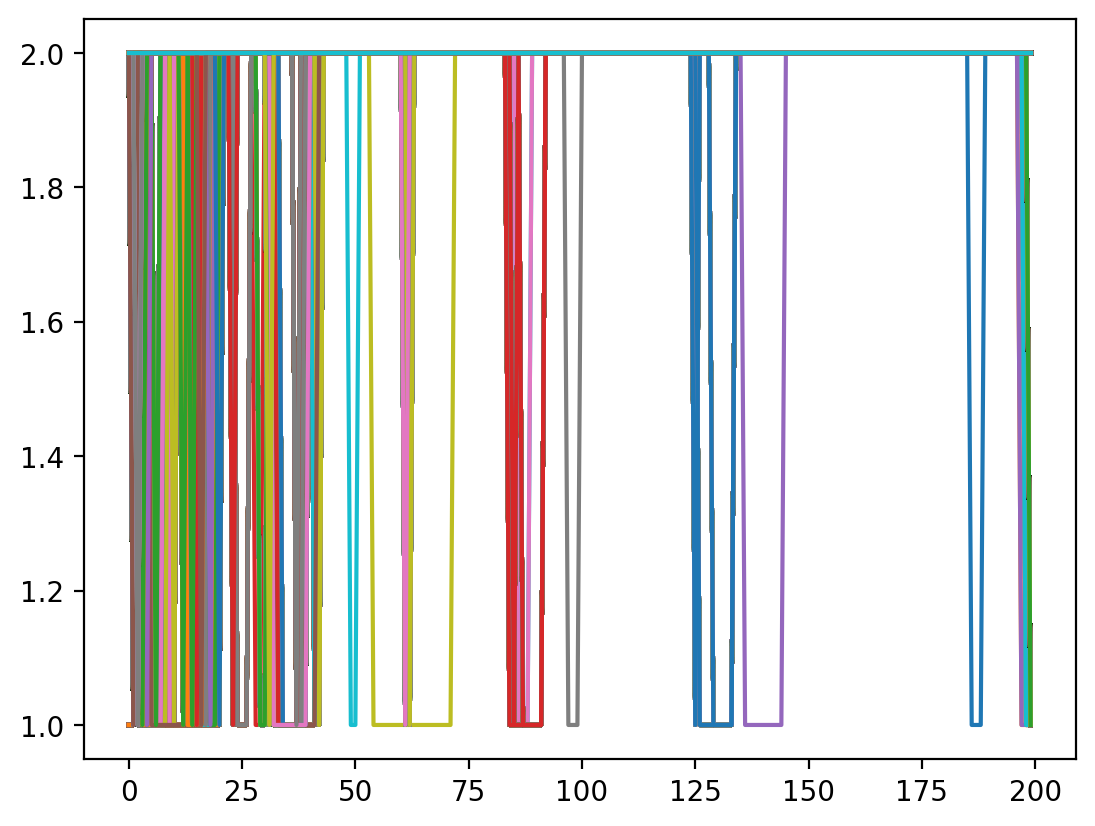

In [37]:
plt.figure(dpi=200)
for key in keys:
    a = results[keys[i]]
    a = a.to("cpu").numpy()
    for i in range(a.shape[0]):
        
        plt.plot(a[i,:])

In [38]:
# plt.plot(a[2,:]/2, label = "s")
plt.plot(b[2,:,1], label = "alpha")
plt.plot(data[2,:,1]/1000, label = "traj")

plt.legend()

NameError: name 'b' is not defined

In [ ]:
b

In [ ]:
model(data)

In [ ]:
import torch.nn as nn

In [ ]:
relu = nn.ReLU()

In [ ]:
test = torch.randn(10,10,2)

In [ ]:
relu(test)

tensor([[[1.2636, 0.2244],
         [0.0000, 1.1753],
         [1.8726, 0.8369],
         [0.0000, 0.3174],
         [0.0000, 0.0000],
         [0.3831, 0.2239],
         [0.0000, 0.0285],
         [1.2042, 0.7172],
         [0.0000, 0.9031],
         [1.4999, 0.0000]],

        [[0.6770, 0.0000],
         [0.0000, 0.0000],
         [1.7903, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.7431],
         [0.1999, 0.0000],
         [0.5755, 1.1027],
         [0.0366, 0.3679],
         [1.5911, 1.9556],
         [0.0000, 0.0000]],

        [[1.2891, 0.5908],
         [0.6584, 1.2545],
         [0.4158, 0.0000],
         [0.0000, 0.0000],
         [0.4222, 0.8100],
         [0.6134, 0.8446],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.1353, 0.0760],
         [0.0000, 0.0000]],

        [[0.6706, 1.5282],
         [0.0000, 0.3768],
         [0.3606, 0.0000],
         [0.6023, 0.3436],
         [0.0000, 0.7277],
         [0.0000, 1.4987],
         [0.0000, 0.13